In [1]:
from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 0.005, 0.001, 0.0005, 0.0001]

#  $m=n=50$

In [4]:
m = n = 50
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.0005

mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=4.9820e-01


In [5]:
Z_star_1, Z_star_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-0.00025147007431084616), -0.0002514700754545629, 
cvxpy constraint violation: 6.295740604192468e-07


In [9]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
lamb_max=0.49819795677752865
Method                 Obj          Viol
----------------------------------------
PDHG          -2.341528e-04  7.773564e-03
PDHG DS       -2.411904e-04  7.345156e-03
PDHG Acc      -2.341528e-04  7.773564e-03
HPDHG DS      -2.325841e-04  1.198559e-02
reHPDHG DS    -2.412590e-04  1.618453e-03
HPDHG         -2.325841e-04  1.198559e-02
reHPDHG       -2.342822e-04  2.383884e-03


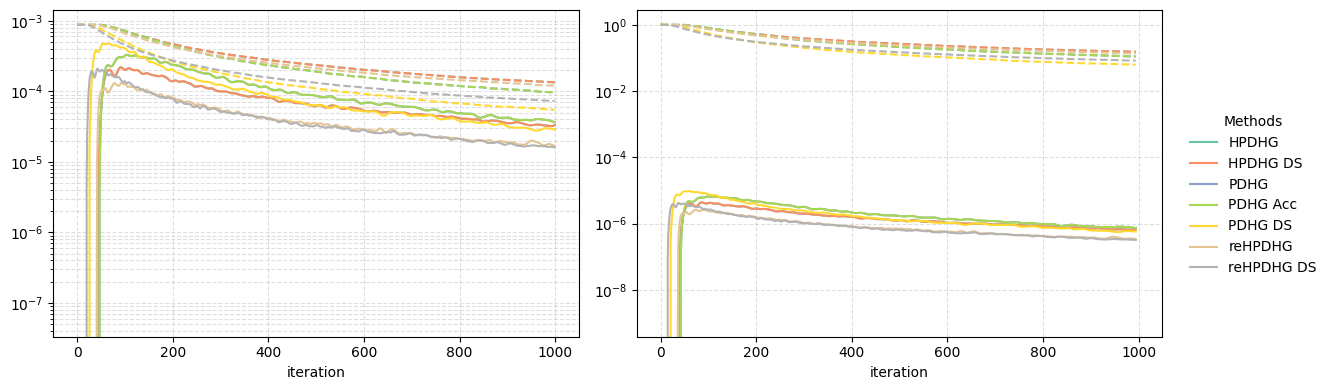

In [10]:
plot_residuals_compare(residuals, dpi=100, dual_scale=True,
                    #    abs_ylim=(1e-3, 1e-1), rel_ylim=(1e-3, 2)
                       )

#  $m=n=1000$

In [11]:
m = n = 100
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=1.1851e+00


In [12]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.005, lamb_max=1.1851e+00
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
Method                 Obj          Viol
----------------------------------------
PDHG          -4.949452e-01  4.011968e-02
PDHG DS       -4.976644e-01  2.596106e-02
PDHG Acc      -4.949452e-01  4.011968e-02
HPDHG DS      -4.957126e-01  2.074472e-02
reHPDHG DS    -4.984137e-01  6.778888e-03
HPDHG         -4.957126e-01  2.074472e-02
reHPDHG       -4.954822e-01  1.154204e-02
beta=0.001, lamb_max=1.1851e+00
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
lamb_max=0.9930835673379561
Method                 Obj          Viol
----------------------------------------
PDHG          -1.000250e-01  8.075328e-02
PDHG DS       -1.001589e-01  5.711282e-02
PD

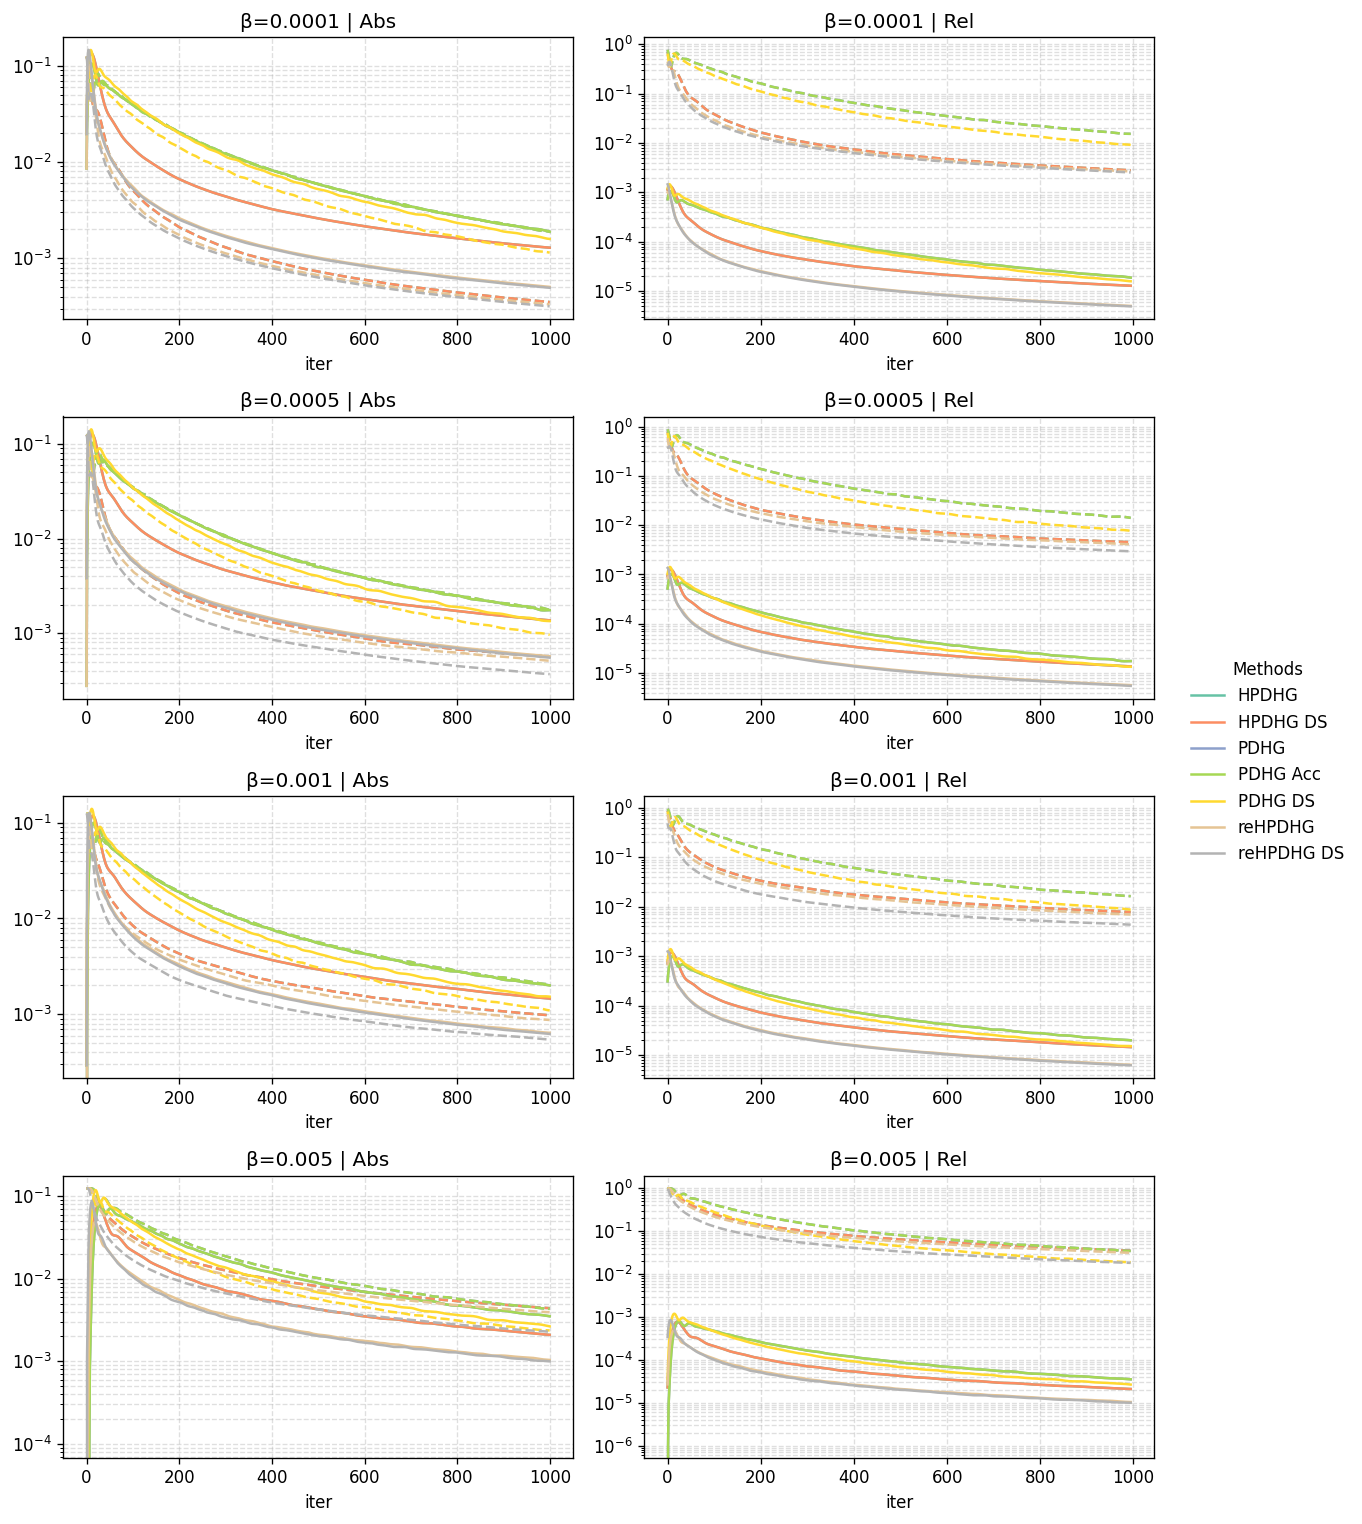

In [13]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

#  $m=n=1000$

In [14]:
m = n = 100
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=1.0044e+00


In [15]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()
 
    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.005, lamb_max=1.0044e+00
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
Method                 Obj          Viol
----------------------------------------
PDHG          -4.438342e-02  1.564210e-02
PDHG DS       -4.661454e-02  1.319263e-02
PDHG Acc      -4.438342e-02  1.564210e-02
HPDHG DS      -4.383138e-02  1.058371e-02
reHPDHG DS    -4.663831e-02  5.684212e-03
HPDHG         -4.383138e-02  1.058371e-02
reHPDHG       -4.441492e-02  7.216796e-03
beta=0.001, lamb_max=1.0044e+00
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
lamb_max=1.0043901944642755
Method                 Obj          Viol
----------------------------------------
PDHG          -9.747243e-03  2.394971e-02
PDHG DS       -9.866763e-03  2.630816e-02
PD

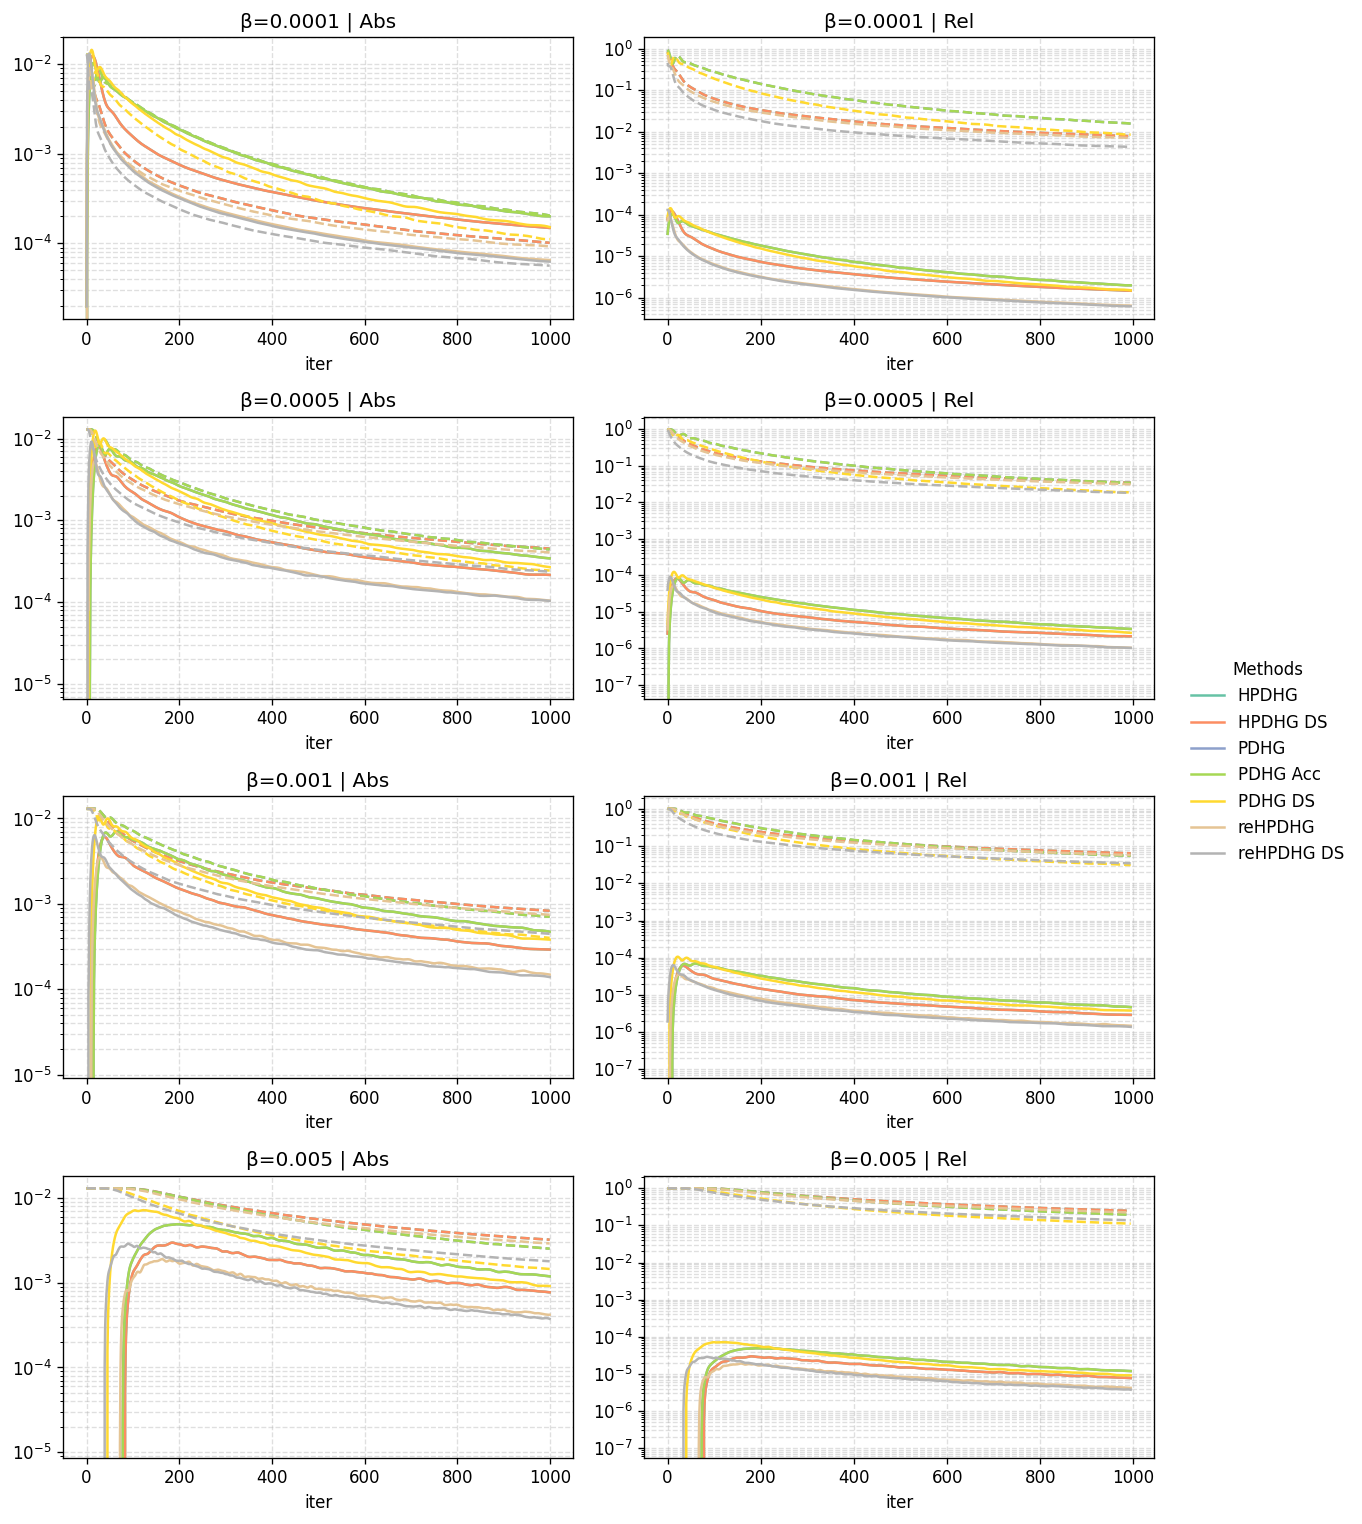

In [16]:
_ = plot_residuals_grid_by_param(residuals,  param_name='beta')